In [ ]:
!apt-get install swig -y
!pip install box2d-py

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (964 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 121753 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubunt

In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display, clear_output
import time

In [ ]:
class NeuralQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(NeuralQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

In [ ]:
class DeepQLearningAgent():
    def __init__(self, state_dim, action_dim, batch_size=64, learning_rate=1e-4, discount_factor=0.99, memory_capacity=100000, update_frequency=5, soft_update_rate=1e-3):
        self.action_dim = action_dim
        self.evaluation_network = NeuralQNetwork(state_dim, action_dim)
        self.target_network = NeuralQNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.evaluation_network.parameters(), lr=learning_rate)
        self.loss_function = nn.MSELoss()
        self.experience_replay = ExperienceReplay(memory_capacity, batch_size)
        self.batch_size = batch_size
        self.discount_factor = discount_factor
        self.update_frequency = update_frequency
        self.soft_update_rate = soft_update_rate
        self.learning_counter = 0

    def select_action(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0)
        self.evaluation_network.eval()
        with torch.no_grad():
            action_values = self.evaluation_network(state)
        self.evaluation_network.train()

        if random.random() > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_dim))

    def store_experience(self, state, action, reward, next_state, done):
        self.experience_replay.add(state, action, reward, next_state, done)

    def optimize_model(self):
        if len(self.experience_replay) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.experience_replay.sample()

        future_q_values = self.target_network(next_states).detach().max(1)[0].unsqueeze(1)
        expected_q_values = rewards + (self.discount_factor * future_q_values * (1 - dones))
        current_q_values = self.evaluation_network(states).gather(1, actions)

        loss = self.loss_function(current_q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.learning_counter += 1
        if self.learning_counter % self.update_frequency == 0:
            self.perform_soft_update()

    def perform_soft_update(self):
        for target_param, eval_param in zip(self.target_network.parameters(), self.evaluation_network.parameters()):
            target_param.data.copy_(self.soft_update_rate * eval_param.data + (1.0 - self.soft_update_rate) * target_param.data)

In [ ]:
class ExperienceReplay():
    def __init__(self, capacity, batch_size):
        self.memory = deque(maxlen=capacity)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [ ]:
def train_agent(env, agent, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.select_action(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.store_experience(state, action, reward, next_state, done)
            agent.optimize_model()
            state = next_state
            score += reward
            if done:
                break
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores[-100:])), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores[-100:])))
    return scores

In [ ]:
def plot_scores(scores):
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [ ]:
def test_agent(env, agent, n_episodes=10):
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        while True:
            action = agent.select_action(state, 0)
            state, reward, done, _ = env.step(action)
            score += reward
            if done:
                break
        print('Episode {}\tScore: {:.2f}'.format(i_episode, score))

Episode 100	Average Score: -179.29
Episode 200	Average Score: -118.37
Episode 300	Average Score: -50.90
Episode 400	Average Score: -25.10
Episode 500	Average Score: -1.51
Episode 600	Average Score: 98.11
Episode 700	Average Score: 146.96
Episode 800	Average Score: 183.94
Episode 900	Average Score: 235.87
Episode 1000	Average Score: 235.03


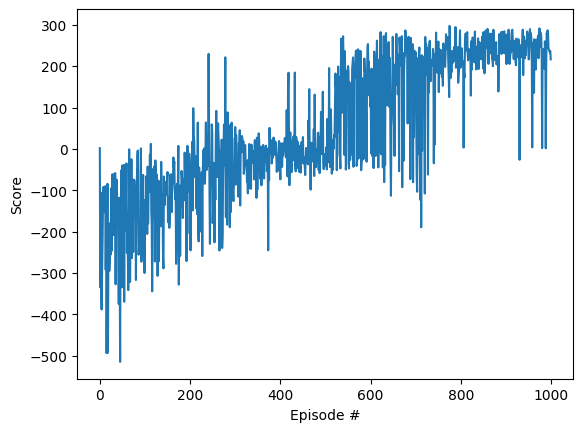

Episode 1	Score: 270.57
Episode 2	Score: 227.27
Episode 3	Score: 258.34
Episode 4	Score: 232.22
Episode 5	Score: 218.42
Episode 6	Score: 267.11
Episode 7	Score: 261.05
Episode 8	Score: 105.59
Episode 9	Score: 286.78
Episode 10	Score: 240.46


In [ ]:
env = gym.make('LunarLander-v2')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DeepQLearningAgent(state_dim, action_dim)

scores = train_agent(env, agent)
plot_scores(scores)
test_agent(env, agent)

In [ ]:
def score_frame(img, score):
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    draw.text((20, 20), f"Score={score: .2f}", fill=(255, 255, 255))
    return np.array(img)

def display_frames_as_images(frames):
    for frame in frames:
        clear_output(wait=True)
        plt.figure(figsize=(10, 8))
        plt.imshow(frame)
        plt.axis('off')
        plt.show()
        time.sleep(0.1)

def visualize_frames(env, agent, epsilon=0, loop=3):
    frames = []
    for i in range(loop):
        state = env.reset()
        score = 0
        for _ in range(500):
            frame = env.render(mode="rgb_array")
            frames.append(score_frame(frame, score))
            action = agent.select_action(state, epsilon)
            state, reward, done, _ = env.step(action)
            score += reward
            if done:
                break
    env.close()
    display_frames_as_images(frames)

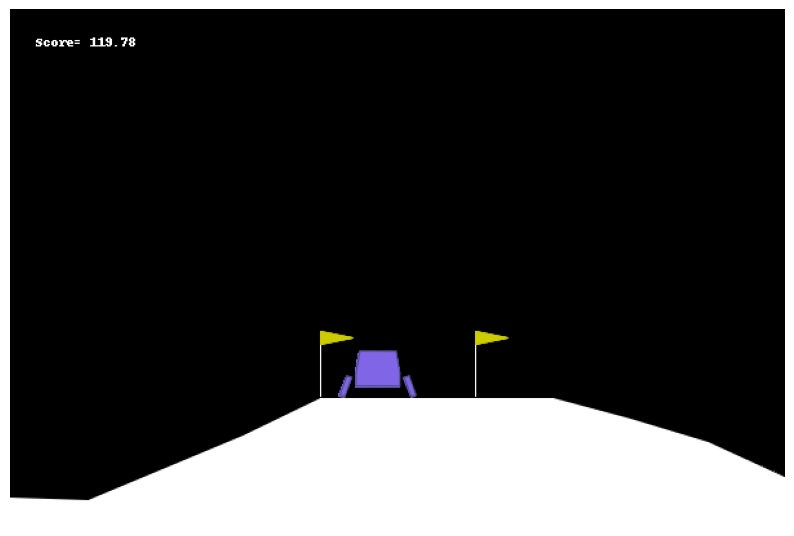

In [ ]:
visualize_frames(env, agent, epsilon=0, loop=1)